# Global Path Variables

In [ ]:
base_path = "drive/MyDrive/Medical Data/"
EDA = "drive/MyDrive/Medical Data/EDA/"
pre_processing = "drive/MyDrive/Medical Data/PreProcessing/"
resnet50 = "/content/drive/MyDrive/Medical Data/ResNet50/"

# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import cv2
import gc

# Importing Deep learning Libraries
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import (InputLayer, BatchNormalization, Dropout, Flatten,
                                     Dense, Activation, MaxPool2D, GlobalAveragePooling2D,
                                     Conv2D, MaxPooling2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, ReduceLROnPlateau
from keras import optimizers, Input
from keras.utils import plot_model
from keras.applications.imagenet_utils import decode_predictions
from keras.optimizers import Adam, RMSprop
from keras.metrics import Precision, Recall, AUC
from keras.backend import clear_session

# Pretrained model preprocess
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras.applications.xception import preprocess_input as xception_preprocess
from keras.applications.resnet import preprocess_input as resnet50_preprocess

# Pretrained models
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50


# Image read and show
import skimage.io
from skimage.io import imread, imshow

# Metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

2.12.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit memory growth for the GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the Dataset from h5 file..


In [ ]:
def load_hdf5_data(hdf5_path):
    f = h5py.File(hdf5_path, 'r')
    return f['image'], f['image_name'], f['image_label']

train_images, train_names, train_labels = load_hdf5_data(f'{base_path}Dataset5_raw_train.h5')
val_images, val_names, val_labels = load_hdf5_data(f'{base_path}Dataset5_raw_val.h5')
test_images, test_names, test_labels = load_hdf5_data(f'{base_path}Dataset5_raw_test.h5')

In [ ]:
print(f"train_images shape and dtype : {train_images.shape} , {train_images.dtype} and train_labels shape and dtype : {train_labels.shape} , {train_labels.dtype}")
print(f"val_images shape : {val_images.shape} and train_labels shape : {val_labels.shape}")
print(f"test_images shape : {test_images.shape} and train_labels shape : {test_labels.shape}")

train_images shape and dtype : (19610, 224, 224, 3) , float16 and train_labels shape and dtype : (19610, 1) , float64
val_images shape : (6534, 224, 224, 3) and train_labels shape : (6534, 1)
test_images shape : (6540, 224, 224, 3) and train_labels shape : (6540, 1)


In [ ]:
def get_label_counts(labels):
    # Convert the HDF5 dataset to a numpy array first
    labels_np = np.array(labels)

    # Get the unique labels and their counts
    unique_labels, counts = np.unique(labels_np, return_counts=True)

    # Create a dictionary of label to count
    label_counts = dict(zip(unique_labels, counts))

    return label_counts

train_label_counts = get_label_counts(train_labels)
val_label_counts = get_label_counts(val_labels)
test_label_counts = get_label_counts(test_labels)

print("Training label counts:", train_label_counts)
print("Validation label counts:", val_label_counts)
print("Test label counts:", test_label_counts)


Training label counts: {0.0: 2512, 1.0: 3607, 2.0: 6115, 3.0: 4438, 4.0: 2938}
Validation label counts: {0.0: 836, 1.0: 1202, 2.0: 2038, 3.0: 1479, 4.0: 979}
Test label counts: {0.0: 838, 1.0: 1203, 2.0: 2039, 3.0: 1480, 4.0: 980}


# Class Label to Disease Name Mapping Dict

In [ ]:
"""
COVID-19 :  4,189 : 0
Lung-Opacity : 6,012 : 1
Normal : 10,192 : 2
Viral Pneumonia : 7,397 : 3
Tuberculosis : 4,897 : 4
"""

Label_ClassName_Dict = {
    0 : "COVID-19",
    1 : "Lung-Opacity",
    2 : "Normal",
    3 : "Viral Pneumonia",
    4 : "Tuberculosis",
}

ClassName_Dict_Label  = {v: k for k, v in Label_ClassName_Dict.items()}

float32 0.08630371 0.7841797 (224, 224, 3) 3
float32 0.0 0.80371094 (224, 224, 3) 3
float32 0.003921509 1.0 (224, 224, 3) 3
float32 0.0 0.9135742 (224, 224, 3) 3
float32 0.1607666 0.8276367 (224, 224, 3) 3


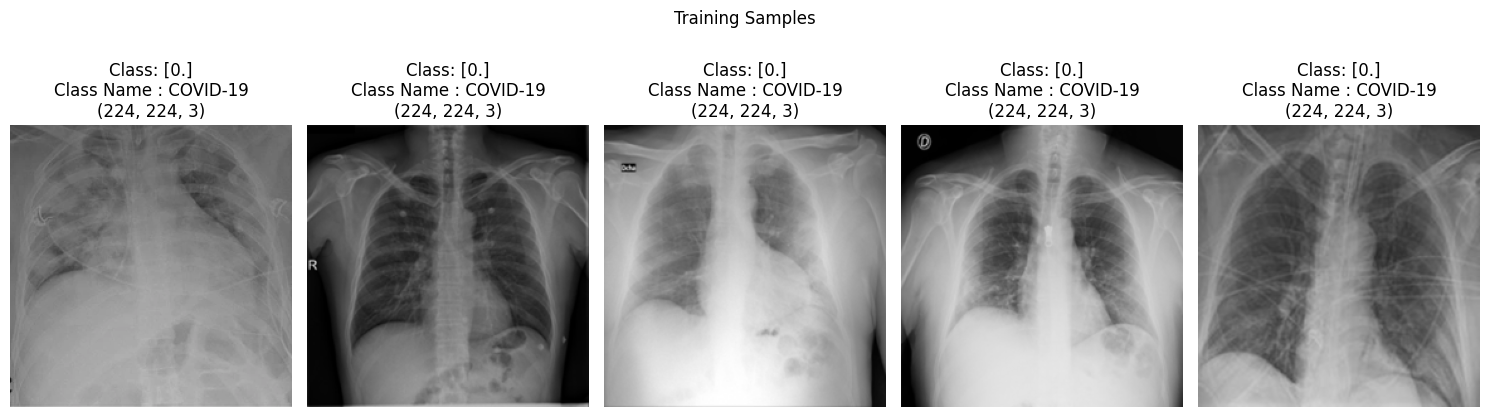

<Figure size 640x480 with 0 Axes>

In [ ]:
def display_samples(images, labels, path, num_samples=5, Type = "Training"):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        image = images[i]
        # Normalize the image if its values are not in the range [0, 1]
        # Convert the image to a suitable dtype
        if image.max() > 1:
            image = (image / 255.0).astype(np.float32)
        else:
            image = image.astype(np.float32)
        print(image.dtype, image.min(), image.max(), image.shape, len(image.shape))
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None) # Use gray colormap if the image is grayscale
        plt.title(f'Class: {labels[i]}\n' + f'Class Name : {Label_ClassName_Dict[int(labels[i].squeeze())]}\n' + f"{image.shape}")
        plt.axis('off')

    plt.suptitle(f"{Type} Samples")
    plt.tight_layout()
    plt.show()
    plt.savefig(path)

display_samples(train_images, train_labels, f"{pre_processing}Image_Samples.png")

# Image Pre-processing
1. CLAHE with grid size of 15 and clip size of 2.
2. Image Shapening with kernels.
3. Zoom for Handling Noise and Other Artifacts in the Dataset


*   Pre-Process : Zoom + Hybrid ( CLAHE + Image Sharpening )




In [ ]:
"""
CLAHE
"""

# Function to apply CLAHE
def apply_clahe(img, grid_size=15, clip_limit=2.0):
    img = img.numpy()  # Convert tensor to numpy array
    img = img.astype(np.uint8)
    grid_size = int(grid_size)
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=(grid_size, grid_size))
    img_clahe = np.zeros_like(img)
    for channel in range(3):
        img_clahe[..., channel] = clahe.apply(img[..., channel])
    return img_clahe

"""
Image Shapening
"""

# kernels = [[[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]], # Basic Sharpening Kernel:
#            [[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]], # Laplacian Sharpening Kernel:
#            [[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]], # Diagonal Edge Sharpening:
#            [[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]], # Exaggerated Sharpening:
#            [[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]], # Another variant of Laplacian:
# ]

kernels = {
    "Basic Sharpening Kernel" : np.array([[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]]),
    "Laplacian Sharpening Kernel" : np.array([[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]]),
    "Diagonal Edge Sharpening" : np.array([[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]]) ,
    "Exaggerated Sharpening" : np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]]),
    "Another variant of Laplacian" : np.array([[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]],) ,
}

# Function to sharpen image
def sharpen_image(img, kernel= kernels["Basic Sharpening Kernel"]):
    img = img.numpy()
    img = img.astype(np.uint8)
    kernel = np.array(kernel)
    return cv2.filter2D(img, -1, kernel)


"""
Zoom Function - Handling Noise and Other Artifacts in the Dataset

1. Cropping / Zoom
2. Data Augmentation
3. Add Noise to the Images
"""

def zoom_into_chest_area(img, zoom_factor=0.83):
    """
    Zooms into the central region of a given X-ray image (assuming the chest area is centrally located).

    Args:
    - img_np: A numpy ndarray representing the X-ray image.
    - zoom_factor: Factor by which to zoom into the image. Values less than 1 zoom in.

    Returns:
    - A numpy ndarray representing the zoomed image.
    """
    img_np = img.numpy().copy().astype("uint8")
    if not isinstance(img_np, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    # Calculate the dimensions of the portion to zoom into
    center_x, center_y = img_np.shape[1] // 2, img_np.shape[0] // 2
    width_zoomed = img_np.shape[1] * zoom_factor
    height_zoomed = img_np.shape[0] * zoom_factor

    # Define ROI boundaries
    x1 = int(center_x - width_zoomed // 2)
    x2 = int(center_x + width_zoomed // 2)
    y1 = int(center_y - height_zoomed // 2)
    y2 = int(center_y + height_zoomed // 2)

    # Extract the region of interest from the image
    zoomed_roi = img_np[y1:y2, x1:x2]

    # Resize the ROI to the original image dimensions
    zoomed_img = cv2.resize(zoomed_roi, (img_np.shape[1], img_np.shape[0]))

    return zoomed_img

def crop_and_resize_image_np(img, crop_percentage=0.1):
    """
    Crops and then resizes a given image using numpy and OpenCV.

    Args:
    - img_np: A numpy ndarray representing the image.
    - crop_percentage: Percentage of the image's height to crop from each side.

    Returns:
    - A numpy ndarray representing the cropped and resized image.
    """

    img_np = img.numpy().copy().astype("uint8")
    if not isinstance(img_np, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    # Calculate the dimensions of the portion to crop
    height, width = img_np.shape[0], img_np.shape[1]

    # Calculate crop size
    crop_size = int(height * crop_percentage)

    # Get the coordinates to crop the image
    x1, x2 = crop_size, width - crop_size
    y1, y2 = crop_size, height - crop_size

    # Crop the image
    cropped_img = img_np[y1:y2, x1:x2]

    # Resize the cropped image to the original dimensions
    resized_img = cv2.resize(cropped_img, (width, height))

    return resized_img

def add_noise_np(img, stddev=0.1):
    """
    Adds Gaussian noise to a given numpy image.

    Args:
    - img_np: A numpy ndarray representing the image.
    - stddev: Standard deviation of the Gaussian noise.

    Returns:
    - A numpy ndarray representing the image with added noise.
    """
    img_np = img.numpy().copy().astype(np.uint8)
    if not isinstance(img_np, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    # Ensure the image is in float32 for the noise addition
    img_float = img_np.astype(np.float32)

    # Create noise and add to the image
    noise = np.random.normal(loc=0, scale=stddev, size=img_np.shape)
    noisy_img = img_float + noise

    # Clip values to [0, 255] if your image has pixel values in that range
    noisy_img_clipped = np.clip(noisy_img, 0, 255)

    # Convert back to uint8
    noisy_img_uint8 = noisy_img_clipped.astype(np.uint8)

    return noisy_img_uint8


"""
Pre-Process and Visualisation Functions
"""

# Apply CLAHE, zoom, and then sharpening transformations to images
def preprocess_images(image, label):
    image = tf.py_function(zoom_into_chest_area, [image], tf.uint8)
    image = tf.py_function(apply_clahe, [image], tf.uint8)
    image = tf.py_function(sharpen_image, [image], tf.uint8)
    return image, label

# Apply CLAHE only to images
def preprocess_images_clahe(image, label, grid_size=15, clip_limit=2.0):
    image = tf.py_function(apply_clahe, [image, grid_size, clip_limit], tf.uint8)
    return image, label

# Apply sharpening transformations only to images
def preprocess_images_sharpen(image, label, kernel):
    image = tf.py_function(sharpen_image, [image, kernel], tf.uint8)
    return image, label

# Visualization function
def visualize_dataset(ds, title, path):
    samples = ds.take(5)
    # print(len(list(samples)))

    plt.figure(figsize=(15, 5))
    i = 0
    for image, label in samples:
        # print(int(label.numpy().squeeze()), label.numpy().shape , len(label.numpy()))
        # print(type(image), image.shape, len(image))
        #image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
        image = image.numpy()
        if image.max() > 1:
            image = (image / 255.0).astype(np.float32)
        else:
            image = image.astype(np.float32)
        # print(image.dtype, image.min(), image.max(), image.shape, len(image.shape))
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.title(f"Label: {Label_ClassName_Dict[int(label.numpy().squeeze())]}")
        plt.axis('off')
        i += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

def visualize(dataset, factors, process_function, sup_title):
    """
    Visualize the images after applying a processing function (zoom or crop_and_resize).
    Args:
    - dataset: A tf.data.Dataset containing the images.
    - factors: A list of factors/percentages to use with the processing function.
    - process_function: The function to process the images.
    - sup_title: The title to add above the visualized images.
    """
    samples = dataset.take(20)
    for image, label in samples:
        plt.figure(figsize=(15, 15))
        for i, factor in enumerate(factors):
            # Apply the processing function
            processed_image = process_function(image, factor)
            # processed_image = processed_image.numpy()

            if processed_image.max() > 1:
                processed_image = (processed_image / 255.0).astype(np.float32)
            else:
                processed_image = processed_image.astype(np.float32)

            plt.subplot(1, len(factors), i+1)
            plt.imshow(processed_image)
            plt.title(f"Factor: {factor}")
            plt.axis("off")
        # plt.suptitle(sup_title)
        # plt.tight_layout()
        plt.show()
        # print()

def rescale_image(img):
    return (img - img.min()) / (img.max() - img.min())

def plot_pixel_intensity_from_dataset(dataset):
    # Compute average pixel intensities
    avg_intensities = [img.numpy().mean() for img, _ in dataset]

    # Plot the histogram
    plt.hist(avg_intensities, bins=30)
    plt.legend()
    plt.title(f'Pixel Intensity Distribution.')
    plt.show()

def test_ds(ds_1, take_num):
  for img, label in ds_1.take(take_num):
    print(img.shape, label.shape)
    print(type(label) , type(img))
    # print(img[0].numpy().min(), img[0].numpy().max(), img[0].numpy().mean())

def test_func_plot(ds, take_num, func_name):
  for (img, label) in ds.take(take_num):
    img , _ = func_name(img,label)
    imshow(img.numpy())
    plt.show()

def test_ds_plot(ds, take_num):
  for img, label in ds.take(take_num):
    print(img.shape, label.shape)
    print(img.numpy().min(), img.numpy().max(), img.numpy().mean())
    print(type(label) , type(img))

    img = img.numpy()
    if img.max() > 1:
        img = (img / 255.0).astype(np.float32)
    else:
        img = img.astype(np.float32)
    imshow(img)
    plt.axis("off")
    plt.show()

## Create Tensorflow Datasets from HDF5 files.


In [ ]:
# Create a TF Dataset
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [ ]:
test_ds(train_dataset, 1)

(224, 224, 3) (1,)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
visualize(train_dataset, [1, 0.85, 0.83, 0.8, 0.75], zoom_into_chest_area, "Zoom Visualization")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
visualize(train_dataset, [0.0, 0.05 , 0.1, 0.15, 0.2], crop_and_resize_image_np, "Zoom Visualization")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
visualize(train_dataset, [0.0, 5.0 , 10.0, 15.0, 20.0], add_noise_np, "Adding Noise")

Output hidden; open in https://colab.research.google.com to view.

## Apply Pre-Processing

In [ ]:
with tf.device('/cpu:0'):
    # Training set Pre-Processing
    train_dataset_preprocessed = train_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Validation set Pre-Processing
    val_dataset_preprocessed = val_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Testing set Pre-Processing
    test_dataset_preprocessed = test_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
def count_elements_in_dataset(dataset):
    count = 0
    for _ , _ in dataset:
        count += 1
    return count

print(count_elements_in_dataset(train_dataset_preprocessed))
print(count_elements_in_dataset(val_dataset_preprocessed))
print(count_elements_in_dataset(test_dataset_preprocessed))

19610
6534
6540


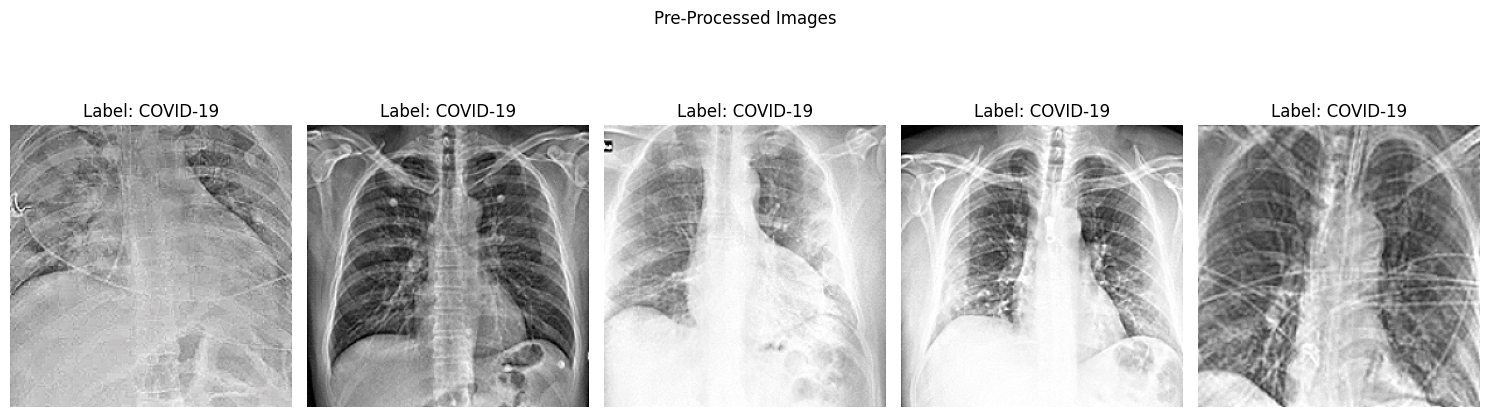

In [ ]:
visualize_dataset(train_dataset_preprocessed, "Pre-Processed Images", f"{pre_processing}PreProcessed_Image_Final.png")

In [ ]:
test_ds(train_dataset_preprocessed, 1)

(224, 224, 3) (1,)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


(224, 224, 3) (1,)
0 255 169.71046582695578
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


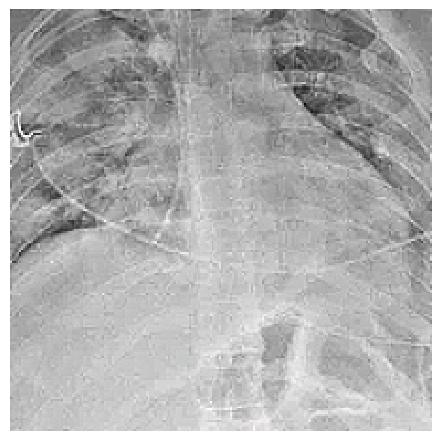

(224, 224, 3) (1,)
0 255 127.30082110969387
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


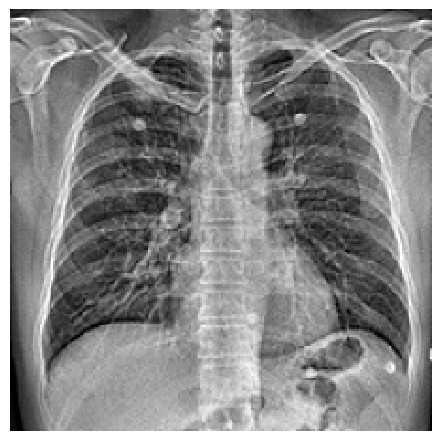

(224, 224, 3) (1,)
0 255 211.86120854591837
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


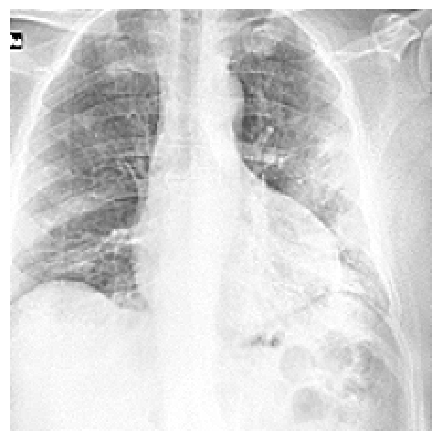

(224, 224, 3) (1,)
0 255 199.15150669642858
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


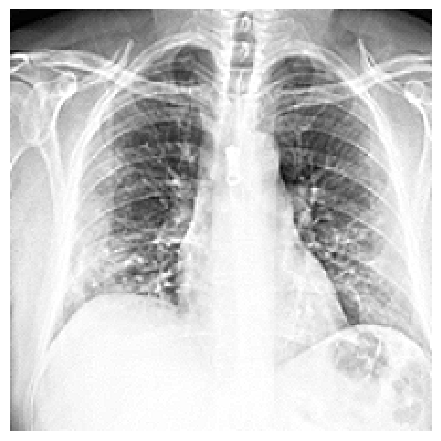

(224, 224, 3) (1,)
22 255 151.01743861607142
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


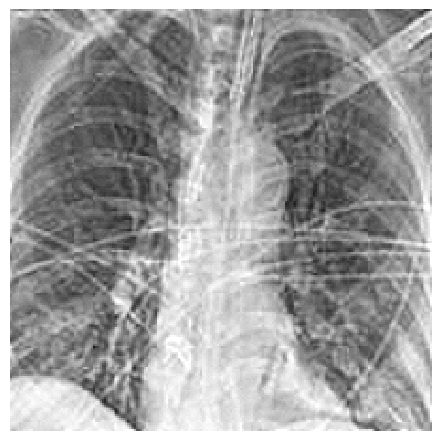

(224, 224, 3) (1,)
0 255 205.87081473214286
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


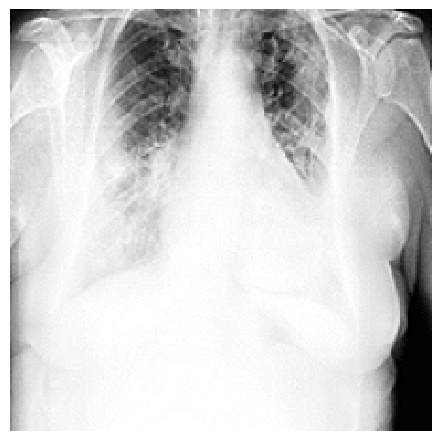

(224, 224, 3) (1,)
0 255 148.1798867984694
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


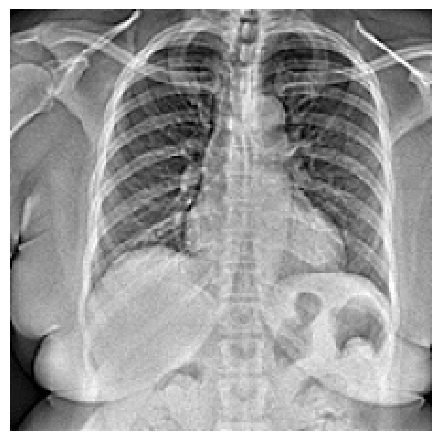

(224, 224, 3) (1,)
0 255 174.53372130102042
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


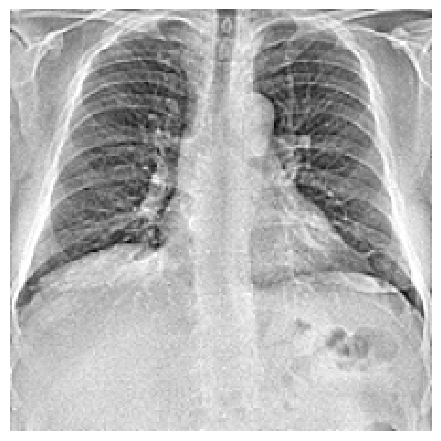

(224, 224, 3) (1,)
0 255 182.36922034438774
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


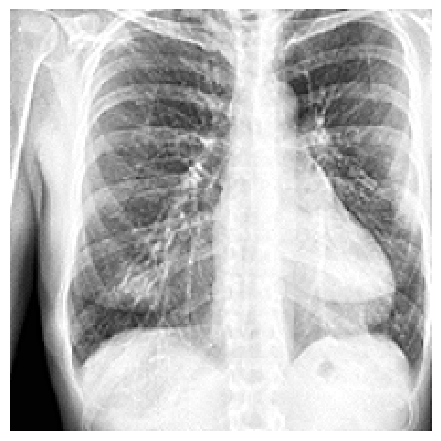

(224, 224, 3) (1,)
25 255 209.33143335459184
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


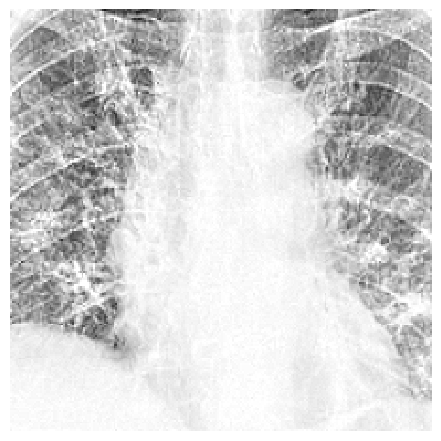

In [ ]:
test_ds_plot(train_dataset_preprocessed, 10)

(224, 224, 3) (1,)
0 255 198.47771843112244
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


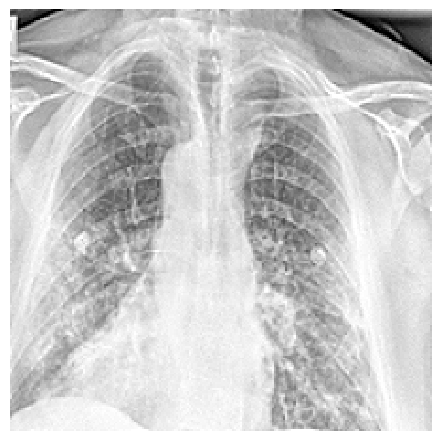

(224, 224, 3) (1,)
3 255 163.19375797193877
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


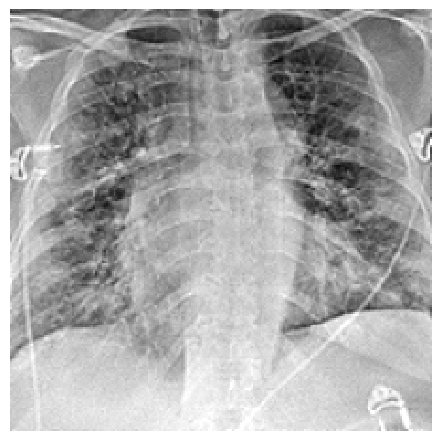

(224, 224, 3) (1,)
0 255 165.99683115433675
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


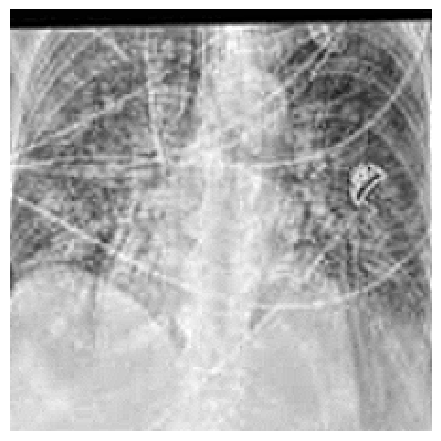

(224, 224, 3) (1,)
0 255 198.66499920280611
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


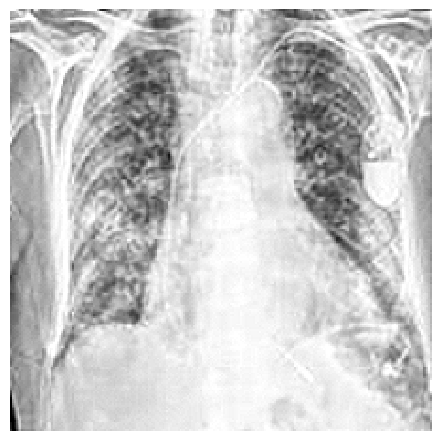

(224, 224, 3) (1,)
24 255 198.0833067602041
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


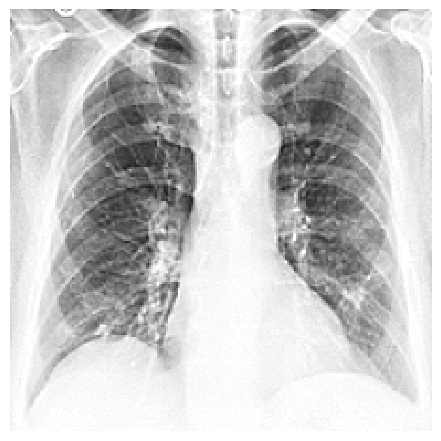

(224, 224, 3) (1,)
0 255 195.79460299744898
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


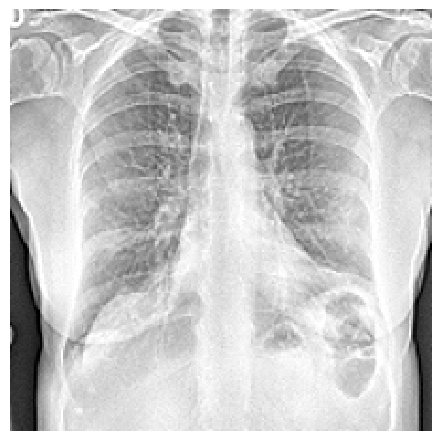

(224, 224, 3) (1,)
0 255 198.70926339285714
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


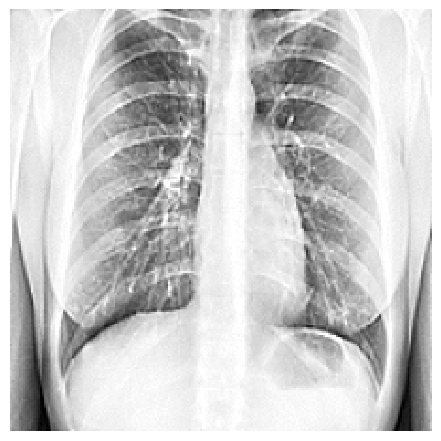

(224, 224, 3) (1,)
0 255 209.63950892857142
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


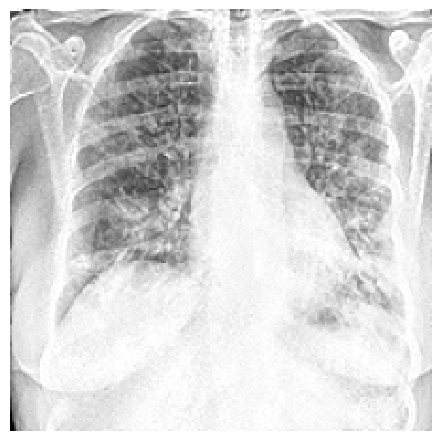

(224, 224, 3) (1,)
0 255 186.28083147321428
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


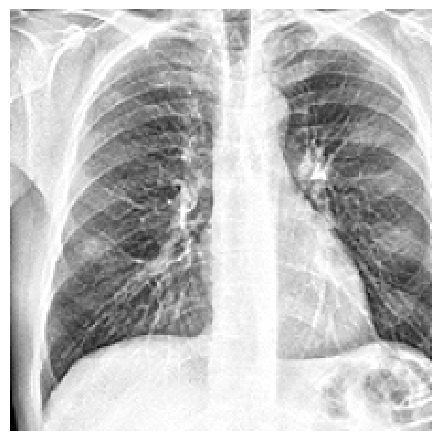

(224, 224, 3) (1,)
18 255 174.6354830994898
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


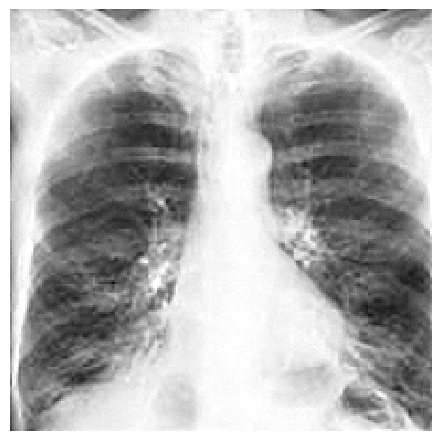

In [ ]:
test_ds_plot(val_dataset_preprocessed, 10)

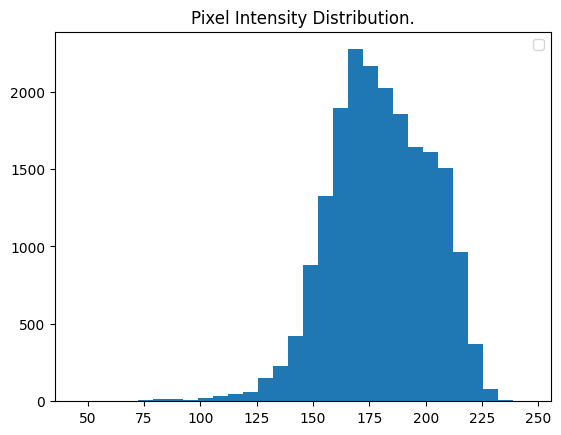

In [ ]:
plot_pixel_intensity_from_dataset(train_dataset_preprocessed)

In [ ]:
test_ds(train_dataset_preprocessed, 1)

(224, 224, 3) (1,)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


# Set Seed and Other Parameters

In [ ]:
Seed = 123
Batch_Size = 128
Image_Size = 224
num_classes = 5
BUFFER_SIZE = 19610
np.random.seed(Seed)
tf.random.set_seed(Seed)

# ResNet50 finetuning

1. Image preprocess

*   scaling + 0 centering
*   Shuffling, Batching and One Hot Encoding

2. Repeated Fine Tuning



## Scaling and 0 centering

In [ ]:
"""
1. ResNet50 Pre Process
"""
# Scaling
def scaling(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
with tf.device('/cpu:0'):
    train_dataset_scaled = train_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset_scaled = val_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset_scaled = test_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
test_ds(train_dataset_scaled, 1)

(224, 224, 3) (1,)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
# Zero Centering
with tf.device('/cpu:0'):

    def accumulate_images(img, label):
        return tf.reduce_sum(img, axis=0), tf.shape(img)[0]

    # Map the accumulate function onto the dataset and reduce to get global sum and count
    accumulated_data = train_dataset_scaled.map(accumulate_images).reduce(
        (tf.zeros([224, 224, 3]), 0),
        lambda x, y: (x[0] + y[0], x[1] + y[1])
    )

    # Compute the mean
    mean_image = accumulated_data[0] / tf.cast(accumulated_data[1], tf.float32)


In [ ]:
# Zero-centering
def zero_center(image, label):
    return image - mean_image, label

with tf.device('/cpu:0'):
      # Apply zero-centering to the datasets
      train_dataset_scaled_centered = train_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      val_dataset_scaled_centered = val_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      test_dataset_scaled_centered = test_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [ ]:
test_ds(train_dataset_scaled_centered, 1)

(224, 224, 3) (1,)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


## Shuffling the images

In [ ]:
print(f"Buffer Size : {BUFFER_SIZE}")

# train_dataset_normalized = train_dataset_normalized.shuffle(BUFFER_SIZE)
train_dataset_scaled_centered = train_dataset_scaled_centered.shuffle(4096)
# test_dataset_scaled_centered = test_dataset_scaled_centered.shuffle(2048)
val_dataset_scaled_centered = val_dataset_scaled_centered.shuffle(2048)

Buffer Size : 19610


In [ ]:
test_ds(train_dataset_scaled_centered, 1)

(224, 224, 3) (1,)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


## Scaling , Batching and One Hot Encoding

In [ ]:
num_classes = 5

def one_hot_encode_batched(images, labels):
    labels = tf.cast(labels, tf.int32)
    labels = tf.one_hot(labels, depth=num_classes)
    labels = tf.squeeze(labels, axis = 1)  # Remove unnecessary dimensions
    return images, labels

In [ ]:
# Scaled , 0 centered dataset Batch and Prefetch
train_dataset_scaled_centered_batched_onehot = (train_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset_scaled_centered_batched_onehot = (val_dataset_scaled_centered
                                              # .shuffle(BUFFER_SIZE)
                                              .batch(Batch_Size)
                                              .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                              # .shuffle(BUFFER_SIZE//Batch_Size)
                                              .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset_scaled_centered_batched_onehot = (test_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
def count_images_in_batched_dataset(dataset):
    count = 0
    for batch in dataset:
        count += batch[0].shape[0]  # Assuming batch is a tuple of (images, labels)
    return count

print(count_images_in_batched_dataset(train_dataset_scaled_centered_batched_onehot))
print(count_images_in_batched_dataset(val_dataset_scaled_centered_batched_onehot))
print(count_images_in_batched_dataset(test_dataset_scaled_centered_batched_onehot))

19610
6534
6540


In [ ]:
test_ds(train_dataset_scaled_centered_batched_onehot, 1)

test_ds(test_dataset_scaled_centered_batched_onehot, 1)

test_ds(val_dataset_scaled_centered_batched_onehot, 1)

(128, 224, 224, 3) (128, 5)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(128, 224, 224, 3) (128, 5)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(128, 224, 224, 3) (128, 5)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
def plot_batch_class_distribution(dataset, num_batches):
    """
    Plots class distribution across batches of a dataset.

    Args:
    - dataset: tf.data.Dataset containing batches of (images, labels).
    - num_batches: Number of batches to consider from the dataset.
    """
    def one_hot_to_class(one_hot_labels):
        return np.argmax(one_hot_labels, axis=-1)

    batch_distributions = []

    # Iterate through batches
    for _, labels in dataset.take(num_batches):
        labels_class = one_hot_to_class(labels.numpy())
        batch_distribution = np.bincount(labels_class, minlength=5)  # Assuming 5 classes, adjust if different
        batch_distributions.append(batch_distribution)

    # Convert to numpy array for easier indexing
    batch_distributions = np.array(batch_distributions)

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 5))
    for class_idx in range(5):  # Assuming 5 classes
        ax.bar(np.arange(len(batch_distributions)), batch_distributions[:, class_idx],
               bottom=np.sum(batch_distributions[:, :class_idx], axis=1), label=f'Class {class_idx}')

    ax.set_xlabel('Batch Number')
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution Across Batches')
    ax.legend()
    plt.show()

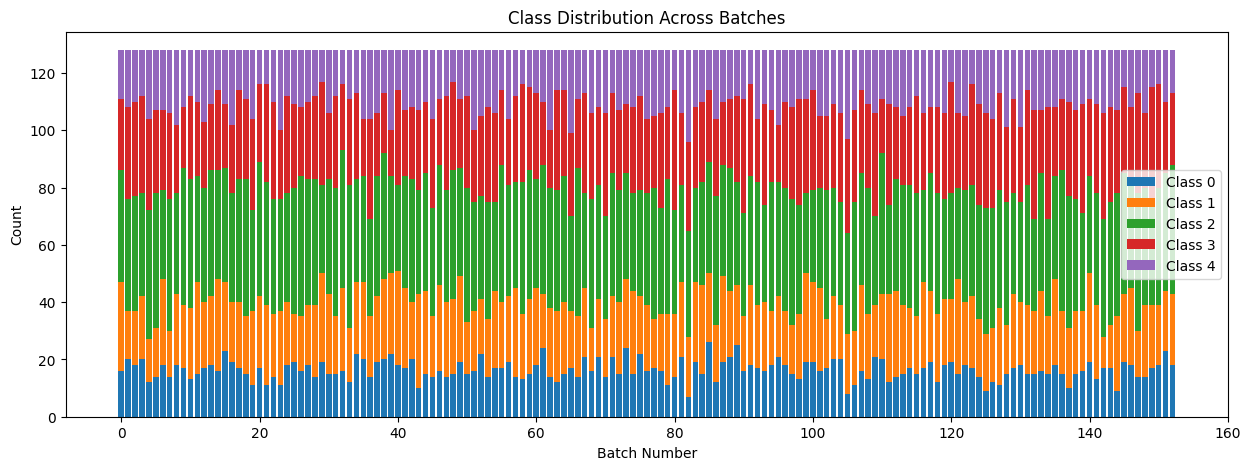

In [ ]:
batch_distributions = []
num_batches = BUFFER_SIZE // Batch_Size
plot_batch_class_distribution(train_dataset_scaled_centered_batched_onehot, num_batches)

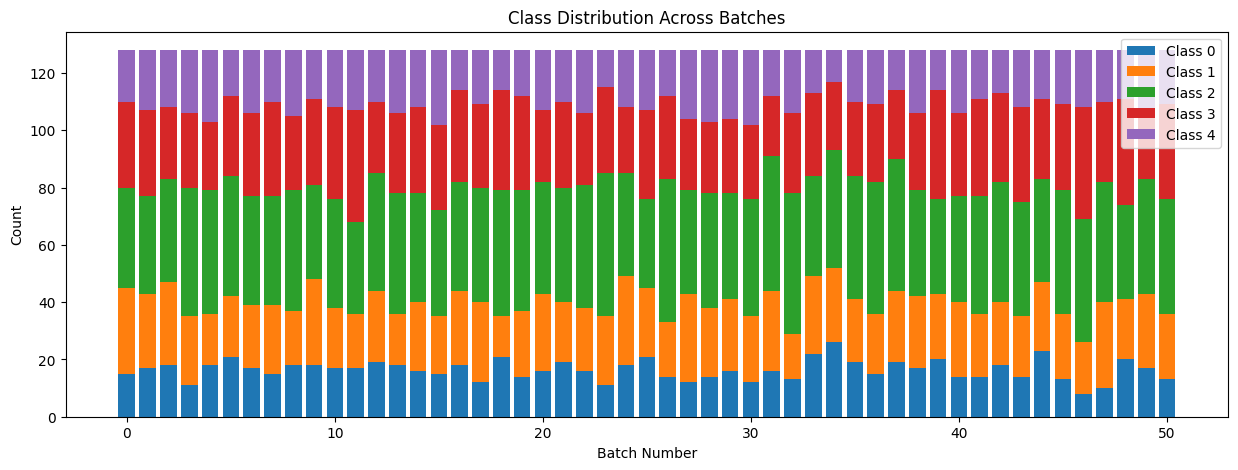

In [ ]:
batch_distributions = []
num_batches = 6534 // Batch_Size
plot_batch_class_distribution(val_dataset_scaled_centered_batched_onehot, num_batches)

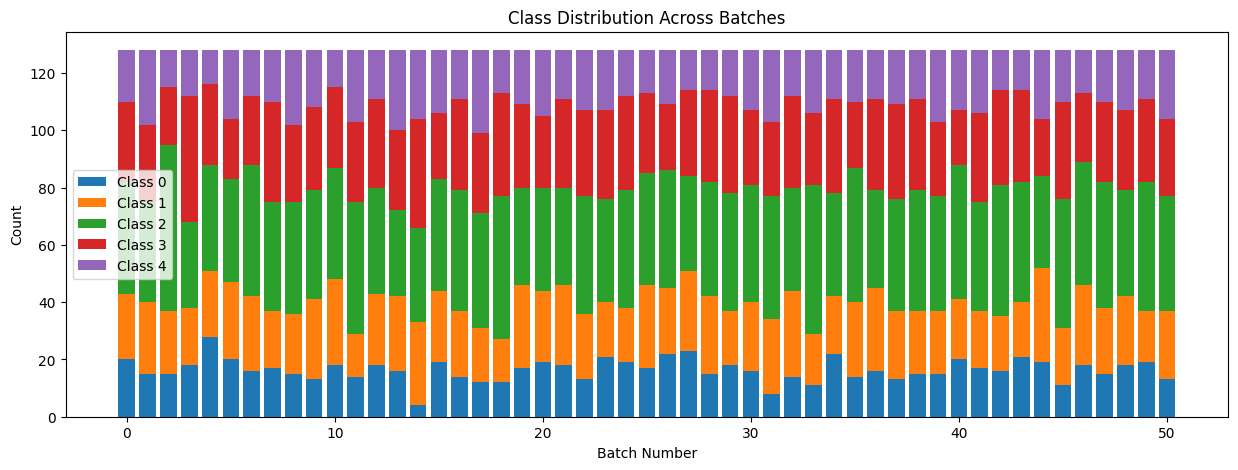

In [ ]:
batch_distributions = []
num_batches = 6540 // Batch_Size
plot_batch_class_distribution(test_dataset_scaled_centered_batched_onehot, num_batches)

## Fine Tuning train_dataset_scaled_centered_batched_onehot Dataset.


In [ ]:
def Confusion_Matrix_Heatmap(y_test,y_pred,class_Names, fName, ModelName):
    #Plot the confusion matrix to understand the classification in detail
    CM = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.heatmap(CM, cmap='Greens', annot=True, fmt='d', xticklabels=class_Names, yticklabels=class_Names)
    plt.title(f'Disease Diagnosis from CXR images - {ModelName}')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.savefig(f"{resnet50}{fName}")
    #plt.show(ax)

# Plot Evaluation Metrics
# sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')
def Eval_Plot(acc,val_acc, loss,val_loss, auc, val_auc, precision, val_precision, path, title):

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(f"{title}\n", fontsize = 15)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize = 15)
    ax1.set_xlabel('Epochs', fontsize = 15)
    ax1.set_ylabel('Accuracy', fontsize = 15)
    ax1.legend(['Training', 'Validation'], fontsize = 15)


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize = 15)
    ax2.set_xlabel('Epochs', fontsize = 15)
    ax2.set_ylabel('Loss', fontsize = 15)
    ax2.legend(['Training', 'Validation'], fontsize = 15)

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC', fontsize = 15)
    ax3.set_xlabel('Epochs', fontsize = 15)
    ax3.set_ylabel('AUC', fontsize = 15)
    ax3.legend(['Training', 'Validation'], fontsize = 15)

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision', fontsize = 15)
    ax4.set_xlabel('Epochs', fontsize = 15)
    ax4.set_ylabel('Precision', fontsize = 15)
    ax4.legend(['Training', 'Validation'], fontsize = 15)

    plt.savefig(f"{resnet50}{path}")
    #plt.show()

In [ ]:
# GCW : Global Class Based Weighting
total_samples = 2512 + 3607 + 6115 + 4438 + 2938

# Calculate the global class-based weights
weights = {
    'COVID-19':  total_samples / (num_classes * 2512),
    'Lung-Opacity':  total_samples / (num_classes * 3607),
    'Normal':  total_samples / (num_classes * 6115),
    'Viral Pneumonia':  total_samples / (num_classes * 4438),
    'Tuberculosis':  total_samples / (num_classes * 2938)
}

int_weights = {ClassName_Dict_Label[key]: value for key, value in weights.items()}
print(int_weights)

{0: 1.5613057324840764, 1: 1.0873301912947047, 2: 0.6413736713000817, 3: 0.8837314105452907, 4: 1.334921715452689}


In [ ]:
steps_per_epoch = total_samples // Batch_Size
print('steps per epoch: ',steps_per_epoch + 1)

steps per epoch:  154


## Delete un-necessary Files to free up System Ram.

In [ ]:
del mean_image
del test_images, test_dataset, test_dataset_preprocessed, test_dataset_scaled, test_dataset_scaled_centered
del train_images, train_dataset, train_dataset_preprocessed, train_dataset_scaled, train_dataset_scaled_centered
del val_images, val_dataset, val_dataset_preprocessed, val_dataset_scaled, val_dataset_scaled_centered
del test_labels, train_labels, val_labels

In [ ]:
del train_names, val_names, test_names
gc.collect()

53

### Clear Keras Backend

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(Image_Size,Image_Size,3),
)

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replace Flatten with GlobalAveragePooling2D
predictions = Dense(5, activation='softmax')(x)  # New fully connected layer for 5 classes

with tf.device('/gpu:0'):
    model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
with tf.device('/gpu:0'):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=METRICS)
    #Freeze the base model to train only the top layers
    for layer in base_model.layers:
        layer.trainable = False

    ###################################################################################

    early_stopping_cb = EarlyStopping(
        monitor='val_auc',           # Which metric to monitor.
        patience=5,                  # Number of epochs with no improvement after which training will be stopped.
        restore_best_weights=True,    # Whether to restore model weights from the epoch with the best value of the monitored quantity.
        verbose=1                     # Logging level. 1 = print logs.
    )

    lr_reduce = ReduceLROnPlateau(monitor='val_auc',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1,
                                  mode='max',
                                  min_lr=0.00000001)

    # best_model_path = f"{resnet50}resnet50_top_trained.h5"
    # checkpoint_cb = ModelCheckpoint(best_model_path,
    #                             monitor='val_auc',
    #                             save_best_only=True,
    #                             verbose=1,
    #                             mode="max")

    plot_model(
    model,
    to_file=f"{resnet50}Architecture.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    )


    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
with tf.device('/gpu:0'):
    epochs = 30
    # Train the model using the fold data
    history_resnet50_scaled_batched = model.fit(train_dataset_scaled_centered_batched_onehot,
                                            validation_data=val_dataset_scaled_centered_batched_onehot,
                                            epochs=epochs,
                                            verbose = 1,
                                            class_weight=int_weights,
                                            callbacks=[early_stopping_cb, lr_reduce])


Epoch 1/30
154/154 [==============================] - 172s 903ms/step - loss: 0.3865 - accuracy: 0.8826 - precision: 0.9027 - recall: 0.8651 - auc: 0.9788 - val_loss: 7.7185 - val_accuracy: 0.1503 - val_precision: 0.1503 - val_recall: 0.1503 - val_auc: 0.4729 - lr: 1.0000e-04
Epoch 2/30
154/154 [==============================] - 151s 888ms/step - loss: 0.3824 - accuracy: 0.8885 - precision: 0.9053 - recall: 0.8691 - auc: 0.9783 - val_loss: 2.0127 - val_accuracy: 0.2264 - val_precision: 0.2267 - val_recall: 0.2245 - val_auc: 0.4758 - lr: 1.0000e-04
Epoch 3/30
154/154 [==============================] - 152s 896ms/step - loss: 0.2941 - accuracy: 0.9099 - precision: 0.9217 - recall: 0.8963 - auc: 0.9864 - val_loss: 7.4938 - val_accuracy: 0.2264 - val_precision: 0.2264 - val_recall: 0.2264 - val_auc: 0.4954 - lr: 1.0000e-04
Epoch 4/30
154/154 [==============================] - 151s 892ms/step - loss: 0.2527 - accuracy: 0.9246 - precision: 0.9341 - recall: 0.9144 - auc: 0.9892 - val_loss: 2.

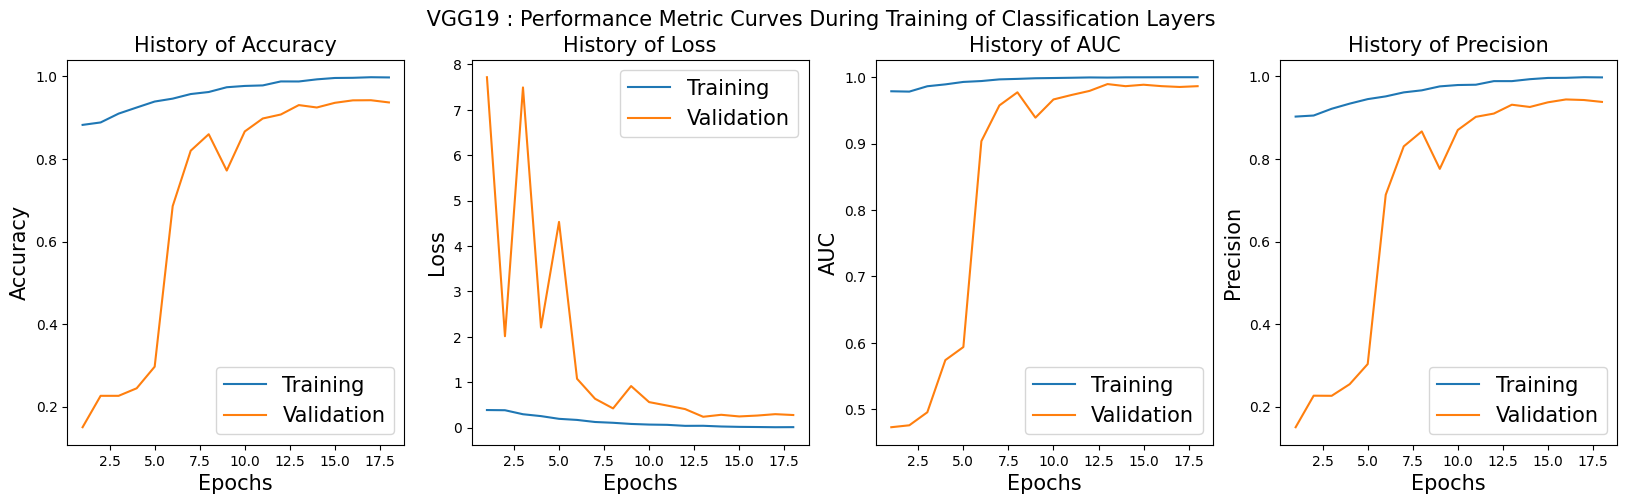

In [ ]:
path = "loss_acc_1.png"
title = " Resnet50 : Performance Metric Curves During Training of Classification Layers"
Eval_Plot(
    history_resnet50_scaled_batched.history['accuracy'],history_resnet50_scaled_batched.history['val_accuracy'],
    history_resnet50_scaled_batched.history['loss'],history_resnet50_scaled_batched.history['val_loss'],
    history_resnet50_scaled_batched.history['auc'],history_resnet50_scaled_batched.history['val_auc'],
    history_resnet50_scaled_batched.history['precision'],history_resnet50_scaled_batched.history['val_precision'],
    path, title
)

In [ ]:
from tensorflow.keras.models import clone_model

best_model_path = f"{resnet50}resnet50_top_trained.h5"
model.save(f'{best_model_path}')
model_top = load_model(f'{best_model_path}', compile=False)

### Finetune entire vgg19 architecture for 100 epochs

In [ ]:
# Unfreeze the entire layer
for layer in base_model.layers:
    layer.trainable = True


###########################################################################


base_model.trainable = True

# Hyperparameters and Callback Settings
epochs = 100
lr_reduction_factor = 0.5
lr_patience = 5
min_lr = 0.000001
early_stopping_patience = 15
best_model_path = f"{resnet50}resnet50.h5"

lr_reduce = ReduceLROnPlateau(monitor='val_auc',
                              factor=lr_reduction_factor,
                              patience=lr_patience,
                              verbose=1,
                              mode='max',
                              min_lr=min_lr)

early_stopping_cb = EarlyStopping(monitor='val_auc',
                                  patience=early_stopping_patience,
                                  restore_best_weights=True,
                                  verbose=1,
                                  mode="max")

checkpoint_cb = ModelCheckpoint(best_model_path,
                                monitor='val_auc',
                                save_best_only=True,
                                verbose=1,
                                mode="max")

with tf.device('/gpu:0'):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=METRICS)

# Display model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Train the model
with tf.device('/gpu:0'):
    history_resnet50_scaled_batched = model.fit(
        train_dataset_scaled_centered_batched_onehot,
        epochs=epochs,
        validation_data=val_dataset_scaled_centered_batched_onehot,
        verbose = 1,
        class_weight=int_weights,
        callbacks = [lr_reduce, early_stopping_cb, checkpoint_cb],)

Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9736 - precision: 0.9744 - recall: 0.9725 - auc: 0.9962
Epoch 1: val_auc improved from -inf to 0.98953, saving model to /content/drive/MyDrive/Medical Data/ResNet50/resnet50.h5
154/154 [==============================] - 161s 911ms/step - loss: 0.0430 - accuracy: 0.9736 - precision: 0.9744 - recall: 0.9725 - auc: 0.9962 - val_loss: 0.2246 - val_accuracy: 0.9415 - val_precision: 0.9424 - val_recall: 0.9395 - val_auc: 0.9895 - lr: 1.0000e-05
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9962 - precision: 0.9963 - recall: 0.9961 - auc: 0.9999
Epoch 2: val_auc did not improve from 0.98953
154/154 [==============================] - 151s 891ms/step - loss: 0.0185 - accuracy: 0.9962 - precision: 0.9963 - recall: 0.9961 - auc: 0.9999 - val_loss: 0.2498 - val_accuracy: 0.9357 - val_precision: 0.9382 - val_recall: 0.9343 - val_auc: 0.9882 - lr: 1.0000e-05
Epoch

### Plots

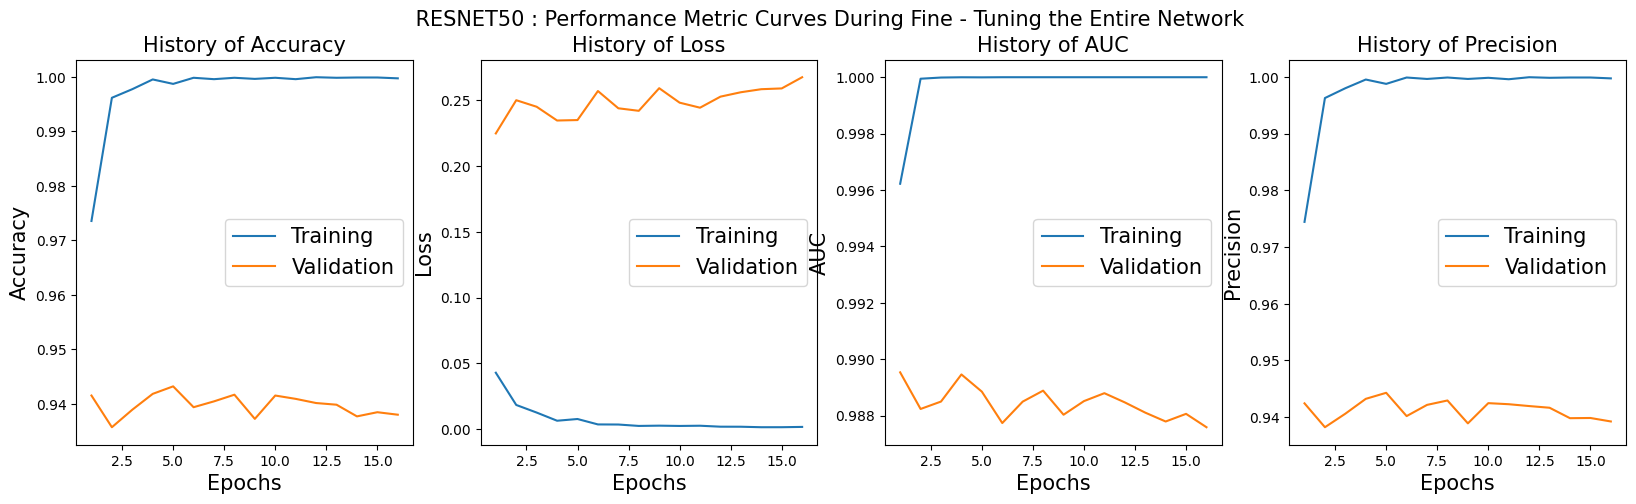

In [ ]:
fname = "loss_acc_2.png"
title = " RESNET50 : Performance Metric Curves During Fine - Tuning the Entire Network"
Eval_Plot(
    history_resnet50_scaled_batched.history['accuracy'],history_resnet50_scaled_batched.history['val_accuracy'],
    history_resnet50_scaled_batched.history['loss'],history_resnet50_scaled_batched.history['val_loss'],
    history_resnet50_scaled_batched.history['auc'],history_resnet50_scaled_batched.history['val_auc'],
    history_resnet50_scaled_batched.history['precision'],history_resnet50_scaled_batched.history['val_precision'],
    fname, title
)

In [ ]:
from tensorflow.keras.models import clone_model

with tf.device('/gpu:0'):
    best_model_path = f"{resnet50}resnet50.h5"
    # Clone the model architecture
    model_prediction = clone_model(model)

    # Load the weights into the new model
    model_prediction.load_weights(best_model_path)
    model.load_weights(f'{best_model_path}')

In [ ]:
# Getting predictions
with tf.device('/gpu:0'):
    predictions = model.predict(test_dataset_scaled_centered_batched_onehot)

y_pred = predictions.argmax(axis=-1)

# Retrieving labels from dataset
y_labels_list = []
for _, labels in test_dataset_scaled_centered_batched_onehot:
    # Here, we're assuming that the labels are one-hot encoded
    # So, we get the integer label for each sample in the batch
    y_labels_list.append(tf.argmax(labels, axis=-1))

# Stacking batches together
y_label = tf.concat(y_labels_list, axis=0).numpy()

# Retrieve class names from the ClassName_Dict_Label
class_Names = [class_name for class_name, _ in sorted(ClassName_Dict_Label.items(), key=lambda item: item[1])]

52/52 [==============================] - 333s 6s/step


In [ ]:
print(y_pred.shape, y_label.shape)
print(class_Names)

(6540,) (6540,)
['COVID-19', 'Lung-Opacity', 'Normal', 'Viral Pneumonia', 'Tuberculosis']


In [ ]:
assert y_pred.shape == y_label.shape

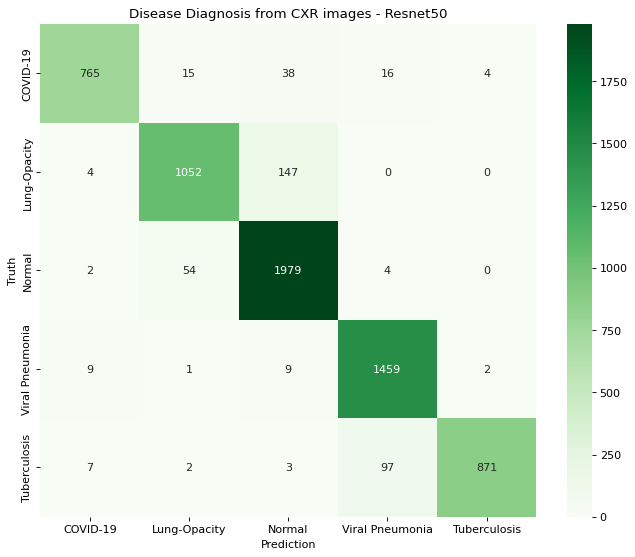

In [ ]:
Confusion_Matrix_Heatmap(y_label, y_pred, class_Names, f"HeatMap.png", "Resnet50")

In [ ]:
print(classification_report(y_label, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       838
           1       0.94      0.87      0.90      1203
           2       0.91      0.97      0.94      2039
           3       0.93      0.99      0.95      1480
           4       0.99      0.89      0.94       980

    accuracy                           0.94      6540
   macro avg       0.95      0.93      0.94      6540
weighted avg       0.94      0.94      0.94      6540



52/52 [==============================] - 28s 544ms/step


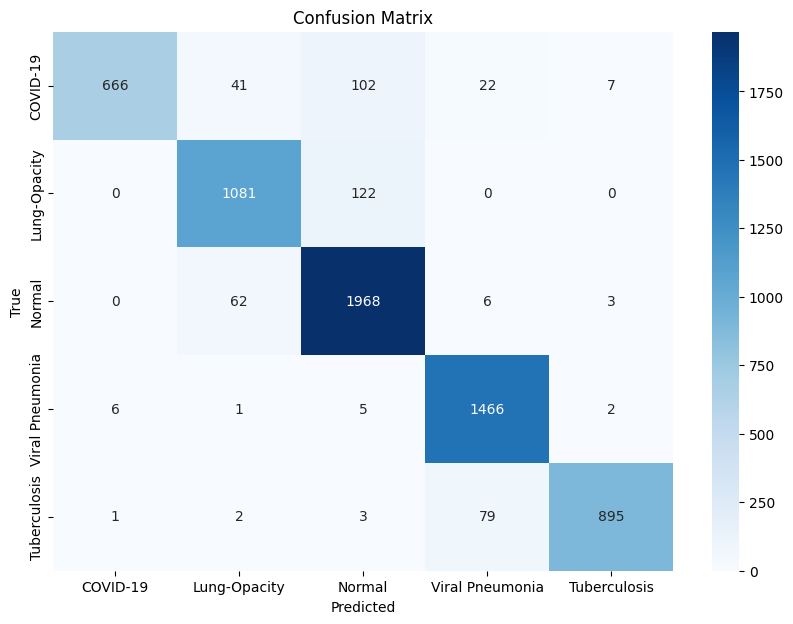

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataset, class_names):
    """
    Plot a confusion matrix heatmap for the given model and dataset.

    Parameters:
    - model: trained Keras model
    - dataset: tf.data.Dataset object
    - class_names: list of class names

    Returns:
    - None (plots the heatmap)
    """

    # Get predictions
    predictions = model.predict(dataset)
    y_pred = np.argmax(predictions, axis=-1)

    # Retrieve true labels from the dataset
    y_labels_list = []
    for _, labels in dataset:
        y_labels_list.append(np.argmax(labels, axis=-1))

    # Flatten the list of batches into a single list
    y_true = np.concatenate(y_labels_list, axis=0)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the heatmap
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Usage example:
class_Names = [class_name for class_name, _ in sorted(ClassName_Dict_Label.items(), key=lambda item: item[1])]
plot_confusion_matrix(model_top, test_dataset_scaled_centered_batched_onehot, class_Names)


In [ ]:
### Scores
scores_Resnet50 = model.evaluate(test_dataset_scaled_centered_batched_onehot)

print(f"Accuracy in test set  : {scores_Resnet50[1]}")
print(f"Precision in test set : {scores_Resnet50[2]}")
print(f"Recall in test set    : {scores_Resnet50[3]}")
print(f"AUC in test set       : {scores_Resnet50[4]}")
# print(f"F1 Metric in test set : {scores_VGG19[5]}")

52/52 [==============================] - 30s 565ms/step - loss: 0.2229 - accuracy: 0.9367 - precision: 0.9398 - recall: 0.9350 - auc: 0.9907
Accuracy in test set  : 0.936697244644165
Precision in test set : 0.9397571682929993
Recall in test set    : 0.9350152611732483
AUC in test set       : 0.9907411336898804


In [ ]:
import pandas as pd
Scores = pd.DataFrame([scores_Resnet50], columns = ["Loss", "Test Accuracy", "Precision", "Recall", "AUC"])
Scores

,Loss,Test Accuracy,Precision,Recall,AUC
0,0.222941,0.936697,0.939757,0.935015,0.990741


In [ ]:
Scores.to_csv(f"{resnet50}score.csv")

# GradCam, activation Visualisation

In [ ]:
del model, model_top, model_prediction

In [ ]:
from tensorflow.keras.models import clone_model

with tf.device('/gpu:0'):
    best_model_path = f"{resnet50}resnet50_top_trained.h5"
    model_top = load_model(f'{best_model_path}', compile=False)

    best_model_path = f"{resnet50}resnet50.h5"
    model_prediction = load_model(f'{best_model_path}', compile=False)

    # Clone the model architecture
    # model = clone_model(model_prediction)
    model.load_weights(f'{best_model_path}')

In [ ]:
# Compile the models
with tf.device('/gpu:0'):
    model_top.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=METRICS)

    model_prediction.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=METRICS)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def make_gradcam_heatmap_new(img_array, model, last_conv_layer_name, pred_index=None):
    # First, create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    # Loop through layers from the next of last_conv_layer to model's output
    for layer_name in [layer.name for layer in model.layers][model.layers.index(last_conv_layer) + 1:]:
        x = model.get_layer(layer_name)(x)

    classifier_model = tf.keras.Model(classifier_input, x)

    # Compute gradient of the predicted class with regard to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradient of the predicted class with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Normalize heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def grad_cam(input_model, image, cls, layer_name, img_size=(224, 224)):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)  # Convert the image to a Tensor

    # Make sure the image tensor has a batch dimension
    if len(image_tensor.shape) < 4:
        image_tensor = tf.expand_dims(image_tensor, 0)

    intermediate_model = tf.keras.models.Model(inputs=input_model.inputs,
                                               outputs=[input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        # Ensure that the operations are being tracked
        tape.watch(image_tensor)

        # Forward pass
        conv_output, predictions = intermediate_model(image_tensor)
        y_c = predictions[0, cls]

    # Compute gradients
    grads = tape.gradient(y_c, conv_output)

    output, grads_val = conv_output[0].numpy(), grads[0].numpy()

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, img_size, cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [ ]:
def get_img_array(img_array):
    # We add a dimension to transform our image array into a "batch"
    # of size (1, 224, 224, 3)
    return np.expand_dims(img_array, axis=0)

def get_gradcam_img(original_img, heatmap, alpha=0.5):
    """
    Superimpose the heatmap on the original image.

    Parameters:
    - original_img: The original image, should be in the range [0, 255].
    - heatmap: The generated heatmap (like Grad-CAM or Guided Grad-CAM).
    - alpha: The intensity factor to superimpose. 1 means only heatmap, 0 means only image.

    Returns:
    - The superimposed image.
    """
    # Ensure the heatmap is in the range [0, 1]
    heatmap = np.uint8(255 * heatmap)

    # Resize heatmap to original image size
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Convert heatmap to colormap for visualization
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the image
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_colored, alpha, 0)
    # jetcam = (np.float32(heatmap_colored) + original_img) / 2

    return np.uint8(superimposed_img)

# Helper function to rescale the image to be between 0 and 255
def rescale_image(image):
    image = 255 * (image - np.min(image)) / (np.max(image) - np.min(image))
    return np.uint8(image)

In [ ]:
# Choose the last conv layer in your model
last_conv_layer_name = "conv5_block3_out"  # This is the last convolutional layer in Resnet50, adjust if necessary
# Remove last layer's softmax
model.layers[-1].activation = None
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Assuming 'model' is your Keras model
for layer in model.layers:
    # Check if the layer uses an activation function
    if hasattr(layer, 'activation'):
        print(f"Layer Name: {layer.name}")
        if layer.activation != None:
          print(f"Activation Function: {layer.activation.__name__}")
          print('------------------------')
        else:
          print("Activation Function Removed.")
          print('------------------------')

Layer Name: conv1_conv
Activation Function: linear
------------------------
Layer Name: conv1_relu
Activation Function: relu
------------------------
Layer Name: conv2_block1_1_conv
Activation Function: linear
------------------------
Layer Name: conv2_block1_1_relu
Activation Function: relu
------------------------
Layer Name: conv2_block1_2_conv
Activation Function: linear
------------------------
Layer Name: conv2_block1_2_relu
Activation Function: relu
------------------------
Layer Name: conv2_block1_0_conv
Activation Function: linear
------------------------
Layer Name: conv2_block1_3_conv
Activation Function: linear
------------------------
Layer Name: conv2_block1_out
Activation Function: relu
------------------------
Layer Name: conv2_block2_1_conv
Activation Function: linear
------------------------
Layer Name: conv2_block2_1_relu
Activation Function: relu
------------------------
Layer Name: conv2_block2_2_conv
Activation Function: linear
------------------------
Layer Name:

## Testing Set Grad Cam

In [ ]:
# Extract sample images
sample_images, sample_labels = next(iter(test_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()

sample_images = sample_images[:10]  # Select the first 10 images
sample_labels = sample_labels[:10]
print(sample_images.shape, sample_labels.shape)

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)

    # Print what the top predicted class is
    with tf.device('/gpu:0'):
        preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")

    cls = np.argmax(preds)
    heatmap = grad_cam(model, img_array, cls, last_conv_layer_name)

    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Create a figure to display images side by side for different alphas
    plt.figure(figsize=(len(alphas)*3, 3))

    for i, alpha in enumerate(alphas):
        superimposed_img = get_gradcam_img(img_display, heatmap, alpha)

        plt.subplot(1, len(alphas), i + 1)
        plt.imshow(superimposed_img)
        plt.title(f"α = {alpha}")
        plt.axis("off")
    print(label, type(label))
    # Setting the super title for the entire subplot
    plt.suptitle(f"Ground Truth: {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
                 f" | Predicted: {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Training Set Gradcam

In [ ]:
# Extract sample images
sample_images, sample_labels = next(iter(train_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()

sample_images = sample_images[:10]  # Select the first 10 images
sample_labels = sample_labels[:10]
print(sample_images.shape, sample_labels.shape)

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    print(img_array.shape)
    # Print what the top predicted class is
    with tf.device('/gpu:0'):
        preds = model_prediction.predict(img_array)

    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    # print(scaled_probabilities)

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")
    # print(f"Predicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    # print(f"Actual : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Use the get_gradcam_img function to superimpose the heatmap on the image
    superimposed_img = get_gradcam_img(img_display, heatmap, alpha=0.4)
    plt.title(f"Ground Truth : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
              f"\nPredicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    plt.axis("off")
    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Validation Set GradCam

In [ ]:
# Extract sample images
sample_images, sample_labels = next(iter(val_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
print(sample_images.shape, sample_labels.shape)

# Select only first 10 images
sample_images = sample_images[:10]
sample_labels = sample_labels[:10]

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    print(img_array.shape)

    # Print what the top predicted class is
    with tf.device('/gpu:0'):
        preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap_new(img_array, model, last_conv_layer_name)

    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Use the get_gradcam_img function to superimpose the heatmap on the image
    superimposed_img = get_gradcam_img(img_display, heatmap, alpha=0.2)

    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(img_display)
    plt.title("Original Image")
    plt.axis("off")

    # Heatmap
    plt.subplot(1, 4, 2)
    plt.imshow(heatmap, cmap ="jet")
    plt.title("Heatmap JET Color Map")
    plt.axis("off")

    # Heatmap
    plt.subplot(1, 4, 3)
    plt.imshow(heatmap)
    plt.title("Heatmap")
    plt.axis("off")

    # Superimposed Image
    plt.subplot(1, 4, 4)
    plt.imshow(superimposed_img)
    plt.title("Superimposed Image")
    plt.axis("off")

    plt.suptitle(f"Ground Truth: {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
                 f" | Predicted: {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Guided Grad Cam

In [ ]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

# Create a new model with modified ReLUs
guided_model = tf.keras.models.clone_model(model, clone_function=lambda l: guidedRelu(l) if isinstance(l, tf.keras.layers.ReLU) else l)

In [ ]:
def guided_backprop(guided_model, img, layer_name):
    # Create a tensor from the image
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # Make sure the image tensor has a batch dimension
    if len(img_tensor.shape) < 4:
        img_tensor = tf.expand_dims(img_tensor, 0)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = guided_model(img_tensor)

        # We can get the most likely class, or we can define it before
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, img_tensor)[0]
    return grads.numpy()

def get_guided_gradcam(gradcam_heatmap, guided_backprop_output):
    # Expand dimensions of gradcam_heatmap from (224,224) to (224,224,3)
    expanded_gradcam = np.expand_dims(gradcam_heatmap, axis=-1)
    cam_gb = np.multiply(expanded_gradcam, guided_backprop_output)
    # Summing along the last dimension to reduce the (224, 224, 3, 3) shape to (224, 224, 3)
    cam_gb = np.sum(cam_gb, axis=-1)
    return cam_gb

## Testing Set

In [ ]:
# Extract sample images
sample_images, sample_labels = next(iter(test_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
print(sample_images.shape, sample_labels.shape)

# Select only first 10 images
sample_images = sample_images[:10]
sample_labels = sample_labels[:10]

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")

    cls = np.argmax(preds)
    heatmap = grad_cam(model, img_array, int(cls), last_conv_layer_name)
    guided_bp = guided_backprop(guided_model, img_array, layer_name=last_conv_layer_name)
    guided_gradcam = get_guided_gradcam(heatmap, guided_bp)

    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Create a figure to display images side by side for different alphas
    plt.figure(figsize=(len(alphas)*3, 3))

    for i, alpha in enumerate(alphas):
        superimposed_img = get_gradcam_img(img_display, guided_gradcam, alpha)

        plt.subplot(1, len(alphas), i + 1)
        plt.imshow(superimposed_img)
        plt.title(f"α = {alpha}")
        plt.axis("off")

    # Setting the super title for the entire subplot
    plt.suptitle(f"Ground Truth: {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
                 f" | Predicted: {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Comparison of Activation Visualization Algorithms : GradCam vs Guided Grad Cam

## Testing Set

In [ ]:
# Extract sample images
sample_images, sample_labels = next(iter(test_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()
print(sample_images.shape, sample_labels.shape)

# Select only first 10 images
sample_images = sample_images[:10]
sample_labels = sample_labels[:10]

last_conv_layer_name = "conv5_block3_out"

# Process each image
for img, label in zip(sample_images, sample_labels):
    img_array = get_img_array(img)
    # print(img_array.shape)
    # Print what the top predicted class is
    preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)

    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    # print(scaled_probabilities)

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }
    print(f"Probabilities : \n{prob}")
    # print(f"Predicted : {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")
    # print(f"Actual : {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}")

    # Generate class activation heatmap
    # heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cls = np.argmax(preds)
    # print(cls)
    heatmap = grad_cam(model, img_array, cls, last_conv_layer_name)
    # Assuming img_array is your original image
    guided_bp = guided_backprop(guided_model, img_array, layer_name=last_conv_layer_name)

    # Normalize guided backpropagation
    guided_bp = rescale_image(np.abs(guided_bp))

    guided_gradcam = get_guided_gradcam(heatmap, guided_bp)

    # Normalize Guided GradCAM
    guided_gradcam = rescale_image(guided_gradcam)

    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Create the GradCAM superimposed image
    gradcam_img = get_gradcam_img(img_display, heatmap, alpha=0.4)

    # Create the Guided GradCAM superimposed image
    superimposed_img = get_gradcam_img(img_display, guided_gradcam, alpha=0.6)

    print(heatmap.shape, guided_bp.shape, guided_gradcam.shape, img_display.shape, gradcam_img.shape , superimposed_img.shape)
    print(heatmap.min(), heatmap.max(), guided_bp.min(), guided_bp.max(), guided_gradcam.min(), guided_gradcam.max())
    plt.figure(figsize=(15, 5))  # Adjust the figure size

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title("Original Image")
    plt.axis("off")

    # Plot GradCAM superimposed image
    plt.subplot(1, 3, 2)
    plt.imshow(gradcam_img)
    plt.title("GradCAM Superimposed")
    plt.axis("off")

    # Plot Guided GradCAM superimposed image
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Guided GradCAM Superimposed")
    plt.axis("off")

    # Setting the super title for the entire subplot
    plt.suptitle(f"Ground Truth: {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
                 f" Predicted: {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Extract sample images
sample_images, sample_labels = next(iter(test_dataset_scaled_centered_batched_onehot.take(1)))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()

# Select only first 10 images
sample_images = sample_images[:10]
sample_labels = sample_labels[:10]

for idx, (img, label) in enumerate(zip(sample_images, sample_labels)):
    img_array = get_img_array(img)

    preds = model_prediction.predict(img_array)
    preds = preds.squeeze()

    min_val = min(preds)
    max_val = max(preds)
    scaled_probabilities = [(value - min_val) / (max_val - min_val) for value in preds]

    prob = {
        "Covid-19" : scaled_probabilities[0],
        "Lung Opacity" : scaled_probabilities[1],
        "Normal" : scaled_probabilities[2],
        "Pneumonia" : scaled_probabilities[3],
        "Tuberculosis" : scaled_probabilities[4],
    }

    cls = np.argmax(preds)
    heatmap = grad_cam(model, img_array, int(cls), last_conv_layer_name)
    # heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    guided_bp = guided_backprop(guided_model, img_array, layer_name=last_conv_layer_name)
    # Normalize guided backpropagation
    guided_bp = rescale_image(np.abs(guided_bp))

    guided_gradcam = get_guided_gradcam(heatmap, guided_bp)

    # Normalize Guided GradCAM
    guided_gradcam = rescale_image(guided_gradcam)

    # Rescale the original image for visualization
    img_display = rescale_image(img)

    # Use the get_gradcam_img function to superimpose the heatmap on the image
    gradcam_superimposed_img = get_gradcam_img(img_display, heatmap, alpha=0.5)

    # Use the get_gradcam_img function to superimpose the heatmap on the image
    superimposed_img = get_gradcam_img(img_display, guided_gradcam, alpha=0.5)

    # Plot Original, Superimposed and Guided GradCAM in a row
    plt.figure(figsize=(20,5))

    plt.subplot(1, 6, 1)
    plt.title("Original Image")
    plt.imshow(img_display)
    plt.axis("off")

    plt.subplot(1, 6, 2)
    plt.title(f"Guided GradCAM Superimposed Image")
    plt.imshow(superimposed_img)
    plt.axis("off")

    plt.subplot(1, 6, 3)
    plt.title("Guided GradCAM")
    plt.imshow(guided_gradcam)
    plt.axis("off")

    plt.subplot(1, 6, 4)
    plt.title("Guided BackProP")
    plt.imshow(guided_bp)
    plt.axis("off")

    plt.subplot(1, 6, 5)
    plt.title("GradCAM Superimposed Image")
    plt.imshow(gradcam_superimposed_img)
    plt.axis("off")

    plt.subplot(1, 6, 6)
    plt.title("GradCAM")
    plt.imshow(heatmap)
    plt.axis("off")

    # Setting the super title for the entire subplot
    plt.suptitle(f"Ground Truth: {Label_ClassName_Dict[int(label.argmax(axis=-1).squeeze())]}" +
                 f" Predicted: {Label_ClassName_Dict[int(preds.argmax(axis=-1).squeeze())]}")

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.